# Optimizing training and inference

In this notebook, we will discuss different ways to reduce memory and compute usage during training and inference.

## Prepare training script (1 point)

When training large models, it is usually a best practice not to use Jupyter notebooks, but run a **separate script** for training which could have command-line flags for various hyperparameters and training modes. This is especially useful when you need to run multiple experiments simultaneously (e.g. on a cluster with task scheduler). Another advantage of this is that after training, the process will finish and free the resources for other users of a shared GPU.

In this part, you will need to put all your code to train a model on Tiny ImageNet that you wrote for the previous task in `train.py`.

You can then run your script from inside of this notebook like this:

In [0]:
!python3 train.py --flag --some_parameter <its value>

**Task** 

Write code for training with architecture from homework_part2

**Requirements**
* Optional arguments from command line such as batch size and number of epochs with built-in argparse
* Modular structure - separate functions for creating data generator, building model and training 


## Profiling time (1 point)

For the next tasks, you need to add measurements to your training loop. You can use [`perf_counter`](https://docs.python.org/3/library/time.html#time.perf_counter) for that:

In [0]:
import time
import numpy as np
import torch

In [0]:
x = np.random.randn(1000, 1000)
y = np.random.randn(1000, 1000)

start_counter = time.perf_counter()
z = x @ y
elapsed_time = time.perf_counter() - start_counter
print("Matrix multiplication took %.3f seconds".format(elapsed_time))

**Task**. You need to add the following measurements to your training script:
* How much time a forward-backward pass takes for a single batch;
* How much time an epoch takes.

## Profiling memory usage (1 point)

**Task**. You need to measure the memory consumptions

This section depends on whether you train on CPU or GPU.

### If you train on CPU
You can use GNU time to measure peak RAM usage of a script:

In [0]:
!/usr/bin/time -lp python train.py

**Maximum resident set size**  will show you the peak RAM usage in bytes after the script finishes.

**Note**. 
Imports also require memory, do the correction

### If you train on GPU

Use [`torch.cuda.max_memory_allocated()`](https://pytorch.org/docs/stable/cuda.html#torch.cuda.max_memory_allocated) at the end of your script to show the maximum amount of memory in bytes used by all tensors.

In [0]:
x = torch.randn(1000, 1000, 1000, device='cuda:0')
print(f"Peak memory usage by Pytorch tensors: {(torch.cuda.max_memory_allocated() / 1024 / 1024):.2f} Mb")

## Gradient based techniques

Modern architectures can potentially consume lots and lots of memory even for minibatch of several objects. To handle such cases here we will discuss two simple techniques.

### Gradient Checkpointing (3 points)

Checkpointing works by trading compute for memory. Rather than storing all intermediate activations of the entire computation graph for computing backward, the checkpointed part does not save intermediate activations, and instead recomputes them in backward pass. It can be applied on any part of a model.

See [blogpost](https://medium.com/tensorflow/fitting-larger-networks-into-memory-583e3c758ff9) for kind introduction and different strategies or [article](https://arxiv.org/pdf/1604.06174.pdf) for not kind introduction.

**Task**. Use [built-in checkpointing](https://pytorch.org/docs/stable/checkpoint.html), measure the difference in memory/compute 

**Requirements**. 
* Try several arrangements for checkpoints
* Add the chekpointing as the optional flag into your script
* Measure the difference in memory/compute between the different arrangements and baseline 

### Solution
I put two checkpointing flags for my model: one for feature extractor part (-checkpoint-backbone), the other one for fully-connected layers (-checkpoint-head). With all the flags off, CUDA reports peak memory usage to be around 3211 Mb. With checkpointing fully-connected layers, the memory consumption decreases to 3209 Mb, which is not much. However, when we checkpoint the backbone part, the memory consumption decreases to 1800 Mb, and the time spent for one epoch goes from 120 seconds to 200 seconds on Colab GPU.

### Accumulating gradient for large batches (3 points)
We can increase the effective batch size by simply accumulating gradients over multiple forward passes. Note that `loss.backward()` simply adds the computed gradient to `tensor.grad`, so we can call this method multiple times before actually taking an optimizer step. However, this approach might be a little tricky to combine with batch normalization. Do you see why?

In [0]:
effective_batch_size = 1024
loader_batch_size = 32
batches_per_update = effective_batch_size / loader_batch_size # Updating weights after 8 forward passes

dataloader = DataLoader(dataset, batch_size=loader_batch_size)

optimizer.zero_grad()

for batch_i, (batch_X, batch_y) in enumerate(dataloader):
    l = loss(model(batch_X), batch_y)
    l.backward() # Adds gradients
  
    if (batch_i + 1) % batches_per_update == 0:
        optimizer.step()
        optimizer.zero_grad()

**Task**. Explore the trade-off between computation time and memory usage while maintaining the same effective batch size. By effective batch size we mean the number of objects over which the loss is computed before taking a gradient step.

**Requirements**

* Compare compute between accumulating gradient and gradient checkpointing with similar memory consumptions
* Incorporate gradient accumulation into your script with optional argument

### Solution
With peak memory consumption of 1800 Mb, grdient checkpointing takes 211 seconds for one epoch. With batches_per_update equalling to 8, accumulating gradient consumes 3211 Mb and takes 155 seconds for one epoch.

## Accuracy vs compute trade-off

### Knowledge distillation (6 points)
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy. We can like train a much smaller network (*student network*) using the outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

**Task:** 
1. Train good enough (teacher) network, achieve >=35% accuracy on validation set.
2. Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"
3. Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.

_Please, don't cheat with early-early-early stopping while training of the student network. Make sure, it  converged._

**Note**. Logits carry more information than the probabilities after softmax


#### We first take the teacher network that achieves 47 % accuracy on test from the homework part 2
**Note:** we assume that best_weights.pth are resulted from runnung homework_part2 notebook

In [4]:
import torch
from train import MyVGGStyleModel

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
teacher = MyVGGStyleModel(False, False, 200).to(device)

MODEL_WEIGHTS = 'best_weights.pth'
teacher.load_state_dict(torch.load(MODEL_WEIGHTS))

Number of model's trainable parameters: 42018568


<All keys matched successfully>

In [0]:
from tiny_img import download_tinyImg200
from train import create_val_folder, get_train_and_val_loaders, get_test_loader, train, evaluate

DATA_PATH = '.'
PATH = 'tiny-imagenet-200/val/images'
ANNOTATIONS = 'tiny-imagenet-200/val/val_annotations.txt'

download_tinyImg200(DATA_PATH)  
create_val_folder(PATH, ANNOTATIONS)

In [8]:
BATCH_SIZE = 128
evaluate(teacher, device, get_test_loader(BATCH_SIZE))

100%|██████████| 79/79 [00:06<00:00, 11.76it/s]

Final results:
  test accuracy:		47.00 %
Achievement unlocked: 110lvl Warlock!


#### Then we create a small student network and train it on hard targets

In [10]:
import torch
import numpy as np
import torch.nn as nn


class StudentNet(nn.Module):
    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.downsample = nn.Conv2d(64, 64, 1, 2)
        
        self.head = nn.Linear(64 * 8 * 8, n_classes)
        
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print("Number of model's trainable parameters: {}".format(params))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.downsample(x)
        x = nn.Flatten()(x)
        out = self.head(x)
        return out
        

student = StudentNet(200).to(device)
input_var = torch.cuda.FloatTensor(1, 3, 64, 64)
output = student(input_var)
output.shape

Number of model's trainable parameters: 889512


torch.Size([1, 200])

In [13]:
LR = 0.001
N_EPOCHS = 20
BATCH_SIZE = 128

train_loader, val_loader = get_train_and_val_loaders(BATCH_SIZE)

opt = torch.optim.Adam(student.parameters(), lr=LR, betas=(0.9, 0.999))
opt.zero_grad()
criterion = nn.CrossEntropyLoss()
STUDENT_WEIGHTS = 'student_weights.pth'

train_losses, val_losses, val_accs = train(student, device, train_loader, val_loader,
                                           opt, criterion, 1, N_EPOCHS, STUDENT_WEIGHTS)

print('Best train loss: {}'.format(min(train_losses)))
print('Best val loss: {}'.format(min(val_losses)))
print('Best validation accuracy: {:.2f}%'.format(max(val_accs) * 100))


  0%|          | 0/625 [00:00<?, ?it/s]

Train dataset size: 80000, Val dataset size: 20000
Epoch 1 started... 



100%|██████████| 625/625 [01:27<00:00,  7.12it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 4.21109676361084



100%|██████████| 157/157 [00:20<00:00,  7.68it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.8490
  Validation accuracy: 			17.80 %
  Saving model weights....
Epoch 1 of 20 took 108.271s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 2 started... 



100%|██████████| 625/625 [01:24<00:00,  7.41it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 3.5409035682678223



100%|██████████| 157/157 [00:19<00:00,  8.08it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.5851
  Validation accuracy: 			21.88 %
  Saving model weights....
Epoch 2 of 20 took 103.774s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 3 started... 



100%|██████████| 625/625 [01:23<00:00,  7.45it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 3.295668840408325



100%|██████████| 157/157 [00:19<00:00,  7.89it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.5485
  Validation accuracy: 			23.11 %
  Saving model weights....
Epoch 3 of 20 took 103.812s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 4 started... 



100%|██████████| 625/625 [01:23<00:00,  7.47it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 3.12636137008667



100%|██████████| 157/157 [00:19<00:00,  8.17it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.3964
  Validation accuracy: 			25.88 %
  Saving model weights....
Epoch 4 of 20 took 102.866s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 5 started... 



100%|██████████| 625/625 [01:22<00:00,  7.59it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.9967434406280518



100%|██████████| 157/157 [00:19<00:00,  8.09it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.3890
  Validation accuracy: 			26.34 %
  Saving model weights....
Epoch 5 of 20 took 101.775s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 6 started... 



100%|██████████| 625/625 [01:23<00:00,  7.46it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.8972339630126953



100%|██████████| 157/157 [00:19<00:00,  8.14it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.3359
  Validation accuracy: 			26.94 %
  Saving model weights....
Epoch 6 of 20 took 103.148s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 7 started... 



100%|██████████| 625/625 [01:22<00:00,  7.58it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.807859420776367



100%|██████████| 157/157 [00:19<00:00,  8.19it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.3323
  Validation accuracy: 			27.14 %
  Saving model weights....
Epoch 7 of 20 took 101.616s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 8 started... 



100%|██████████| 625/625 [01:21<00:00,  7.65it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.741605043411255



100%|██████████| 157/157 [00:19<00:00,  8.21it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2667
  Validation accuracy: 			28.69 %
  Saving model weights....
Epoch 8 of 20 took 100.815s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 9 started... 



100%|██████████| 625/625 [01:22<00:00,  7.61it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.671670436859131



100%|██████████| 157/157 [00:19<00:00,  8.14it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2775
  Validation accuracy: 			28.29 %
Epoch 9 of 20 took 101.410s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 10 started... 



100%|██████████| 625/625 [01:21<00:00,  7.70it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.616694927215576



100%|██████████| 157/157 [00:19<00:00,  8.08it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2693
  Validation accuracy: 			28.64 %
Epoch 10 of 20 took 100.631s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 11 started... 



100%|██████████| 625/625 [01:20<00:00,  7.76it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.560521125793457



100%|██████████| 157/157 [00:18<00:00,  8.28it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2179
  Validation accuracy: 			29.70 %
  Saving model weights....
Epoch 11 of 20 took 99.477s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 12 started... 



100%|██████████| 625/625 [01:21<00:00,  7.66it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.5077922344207764



100%|██████████| 157/157 [00:19<00:00,  8.23it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2891
  Validation accuracy: 			28.78 %
Epoch 12 of 20 took 100.631s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 13 started... 



100%|██████████| 625/625 [01:20<00:00,  7.73it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.4622421264648438



100%|██████████| 157/157 [00:18<00:00,  8.44it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2553
  Validation accuracy: 			29.40 %
Epoch 13 of 20 took 99.434s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 14 started... 



100%|██████████| 625/625 [01:20<00:00,  7.77it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.4241278171539307



100%|██████████| 157/157 [00:18<00:00,  8.28it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2668
  Validation accuracy: 			29.19 %
Epoch 14 of 20 took 99.417s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 15 started... 



100%|██████████| 625/625 [01:20<00:00,  7.74it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.3908135890960693



100%|██████████| 157/157 [00:18<00:00,  8.29it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.4076
  Validation accuracy: 			27.89 %
Epoch 15 of 20 took 99.706s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 16 started... 



100%|██████████| 625/625 [01:21<00:00,  7.67it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.3562142848968506



100%|██████████| 157/157 [00:18<00:00,  8.36it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2754
  Validation accuracy: 			29.64 %
Epoch 16 of 20 took 100.299s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 17 started... 



100%|██████████| 625/625 [01:21<00:00,  7.70it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.3297109603881836



100%|██████████| 157/157 [00:19<00:00,  8.25it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2979
  Validation accuracy: 			28.97 %
Epoch 17 of 20 took 100.183s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 18 started... 



100%|██████████| 625/625 [01:21<00:00,  7.67it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.2960143089294434



100%|██████████| 157/157 [00:19<00:00,  8.19it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.2873
  Validation accuracy: 			29.57 %
Epoch 18 of 20 took 100.667s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 19 started... 



100%|██████████| 625/625 [01:22<00:00,  7.55it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.2613613605499268



100%|██████████| 157/157 [00:19<00:00,  8.12it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  Validation loss: 	3.3191
  Validation accuracy: 			29.20 %
Epoch 19 of 20 took 102.102s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Epoch 20 started... 



100%|██████████| 625/625 [01:22<00:00,  7.60it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  Train Loss: 2.2347562313079834



100%|██████████| 157/157 [00:19<00:00,  8.16it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  Validation loss: 	3.2965
  Validation accuracy: 			29.79 %
  Saving model weights....
Epoch 20 of 20 took 101.557s
Peak memory usage by Pytorch tensors: 2735.20 Mb
Best train loss: 2.2347562313079834
Best val loss: 3.2179408392329125
Best validation accuracy: 29.79%



100%|██████████| 79/79 [00:04<00:00, 16.67it/s]


Final results:
  test accuracy:		24.82 %
We need more magic! Follow instructons below


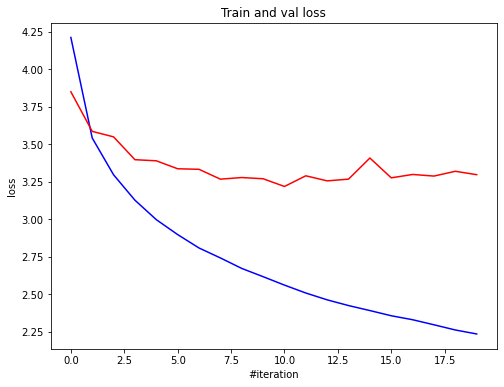

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.title("Train and val loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(train_losses, 'b')
plt.plot(val_losses, 'r')
plt.show()

In [13]:
STUDENT_WEIGHTS = 'student_weights.pth'
student.load_state_dict(torch.load(STUDENT_WEIGHTS))
evaluate(student, device, get_test_loader(BATCH_SIZE))

100%|██████████| 79/79 [00:04<00:00, 17.56it/s]

Final results:
  test accuracy:		24.82 %
We need more magic! Follow instructons below


#### Then finnaly we do the distillation:

In [0]:
from torch.autograd import Variable
import torch.nn.functional as F

def distillation(y, teacher_scores, labels, temperature=4, alpha=0.5):
    p = F.log_softmax(y/temperature, dim=1)
    q = F.softmax(teacher_scores/temperature, dim=1)
    l_kl = F.kl_div(p, q, size_average=False) * (temperature**2) / y.shape[0]
    l_ce = F.cross_entropy(y, labels)
    return l_kl * alpha + l_ce * (1. - alpha)

In [28]:
import time
import tqdm


# load models' state dicts
teacher.load_state_dict(torch.load(MODEL_WEIGHTS))
student.load_state_dict(torch.load(STUDENT_WEIGHTS))

# We freeze the teacher net to save compute time when calling loss backward
for param in teacher.parameters():
    param.requires_grad = False

LR = 0.001
N_EPOCHS = 20
BATCH_SIZE = 128

train_loader, val_loader = get_train_and_val_loaders(BATCH_SIZE)
criterion = nn.CrossEntropyLoss()

STUDENT_DISTILLATED_WEIGHTS = 'student_distillated_weights.pth'
opt = torch.optim.Adam(student.parameters(), lr=LR, betas=(0.9, 0.999))
opt.zero_grad()

student.train(True)
epoch_train_losses = []
for (X_batch, y_batch) in tqdm.notebook.tqdm(train_loader):
    teacher_preds = teacher(torch.FloatTensor(X_batch).to(device))
    student_preds = student(torch.FloatTensor(X_batch).to(device))
    loss = distillation(student_preds, teacher_preds, torch.LongTensor(y_batch).to(device))
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    epoch_train_losses.append(loss.cpu().data.numpy())
    
epoch_train_loss = np.mean(epoch_train_losses)
print('Train Loss: {}'.format(epoch_train_loss))

student.train(False)
epoch_val_losses, epoch_val_accs = [], []
for X_batch, y_batch in tqdm.notebook.tqdm(val_loader):
    
    logits = student(torch.FloatTensor(X_batch).to(device))
    loss = criterion(logits, torch.LongTensor(y_batch).to(device))
    
    y_pred = logits.max(1)[1].data
    
    epoch_val_losses.append(loss.cpu().item())
    epoch_val_accs.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

epoch_val_loss = np.mean(epoch_val_losses)
epoch_val_acc = np.mean(epoch_val_accs)

print("  Validation loss: \t{:.4f}".format(
    epoch_val_loss))
print("  Validation accuracy: \t\t\t{:.2f} %".format(
    epoch_val_acc * 100))

if epoch_val_acc > best_val_acc:
    best_val_acc = epoch_val_acc
    print('Saving model weights....')
    torch.save(student.state_dict(), STUDENT_DISTILLATED_WEIGHTS)

Train dataset size: 80000, Val dataset size: 20000


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Train Loss: 4.79372501373291



  Validation loss: 	2.7489
  Validation accuracy: 			40.06 %


#### Finally, let's evaluate distilled student network on the test data portion

In [29]:
student.load_state_dict(torch.load(STUDENT_DISTILLATED_WEIGHTS))
evaluate(student, device, get_test_loader(BATCH_SIZE))




  0%|          | 0/79 [00:00<?, ?it/s]


  1%|▏         | 1/79 [00:00<00:19,  4.04it/s]


  3%|▎         | 2/79 [00:00<00:18,  4.17it/s]


  6%|▋         | 5/79 [00:00<00:13,  5.58it/s]


  8%|▊         | 6/79 [00:00<00:11,  6.15it/s]


 11%|█▏        | 9/79 [00:00<00:08,  8.06it/s]


 14%|█▍        | 11/79 [00:00<00:07,  8.81it/s]


 18%|█▊        | 14/79 [00:01<00:06, 10.40it/s]


 23%|██▎       | 18/79 [00:01<00:05, 12.02it/s]


 28%|██▊       | 22/79 [00:01<00:04, 13.03it/s]


 33%|███▎      | 26/79 [00:01<00:03, 14.47it/s]


 38%|███▊      | 30/79 [00:02<00:03, 15.29it/s]


 43%|████▎     | 34/79 [00:02<00:02, 16.41it/s]


 48%|████▊     | 38/79 [00:02<00:02, 16.84it/s]


 53%|█████▎    | 42/79 [00:02<00:02, 16.66it/s]


 58%|█████▊    | 46/79 [00:02<00:01, 17.62it/s]


 63%|██████▎   | 50/79 [00:03<00:01, 18.57it/s]


 66%|██████▌   | 52/79 [00:03<00:01, 18.67it/s]


 68%|██████▊   | 54/79 [00:03<00:01, 17.17it/s]


 72%|███████▏  | 57/79 [00:03<00:01, 18.63it/s]


 75%|██████

Final results:
  test accuracy:		28.53 %
Achievement unlocked: 60lvl Warlock!


#### Hooray! The accuracy went from 24.82% to 28.53% on a model with only 800k parameters (we bare in mind that the teacher net has 42M)! Knowlwdge distillation works!

### TL;DR. Moar techniques on accuracy vs time trade-off (just for your information)

### Tensor type size

One of the hyperparameter affecting memory consumption is the precision (e.g. floating point number). The most popular choice is 32 bit however with several hacks* 16 bit arithmetics can save you approximately half of the memory without considerable loss of perfomance. This is called mixed precision training.

*https://arxiv.org/pdf/1710.03740.pdf

### Quantization

We can actually move further and use even lower precision like 8-bit integers:

* https://heartbeat.fritz.ai/8-bit-quantization-and-tensorflow-lite-speeding-up-mobile-inference-with-low-precision-a882dfcafbbd
* https://nervanasystems.github.io/distiller/quantization/
* https://arxiv.org/abs/1712.05877

### Pruning

The idea of pruning is to remove unnecessary (in terms of loss) weights. It can be measured in different ways: for example, by the norm of the weights (similar to L1 feature selection), by the magnitude of the activation or via Taylor expansion*.

One iteration of pruning consists of two steps:

1) Rank weights with some importance measure and remove the least important

2) Fine-tune the model

This approach is a bit computationally heavy but can lead to drastic (up to 150x) decrease of memory to store the weights. Moreover if you make use of structure in layers you can decrease also compute. For example, the whole convolutional filters can be removed.

*https://arxiv.org/pdf/1611.06440.pdf